In [3]:
!jupyter nbconvert --to html Premier_League.ipynb

[NbConvertApp] Converting notebook Premier_League.ipynb to html
[NbConvertApp] WARNING | Alternative text is missing on 15 image(s).
[NbConvertApp] Writing 3339874 bytes to Premier_League.html


# Imports

In [36]:
import pandas as pd
import numpy as np

# Graphs Plot
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns

# SARIMA
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Prophet
from prophet import Prophet

# Fourier - only numpy

# LSTM
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm

# fine tune
import itertools
from itertools import product

# Metrics (mse ,rmse)
from sklearn.metrics import mean_squared_error

# Scaling
from sklearn.preprocessing import MinMaxScaler

# Change Point Detection
!pip install ruptures
import ruptures as rpt

# Feature Engineering

In [ ]:
#read csv
df = pd.read_csv('premier_league_clean.csv')

In [ ]:
df = df[['MatchID', 'Season', 'MatchWeek', 'Date', 'Time',
       'HomeTeam', 'AwayTeam', 'FullTimeHomeTeamGoals',
       'FullTimeAwayTeamGoals', 'FullTimeResult', 'HalfTimeHomeTeamGoals',
       'HalfTimeAwayTeamGoals', 'HalfTimeResult', 'Referee', 'HomeTeamShots',
       'AwayTeamShots', 'HomeTeamShotsOnTarget', 'AwayTeamShotsOnTarget',
       'HomeTeamCorners', 'AwayTeamCorners', 'HomeTeamFouls', 'AwayTeamFouls',
       'HomeTeamYellowCards', 'AwayTeamYellowCards', 'HomeTeamRedCards',
       'AwayTeamRedCards', 'HomeTeamPoints', 'AwayTeamPoints']]

Filter out years before 2014/2015

In [ ]:
df['Date'] = pd.to_datetime(df['Date'])
df = df[df['Date'] >= pd.to_datetime('2014-07-01')]

shift function

In [ ]:
# shift season for merging previous seasons stats
def shift_season(season_str):
    start, end = season_str.split('-')
    return f"{int(start)+1}-{int(end)+1}"

## Referees Details

In [ ]:
full_df = pd.read_csv('premier_league_clean.csv')
full_df.head()

,Unnamed: 0,MatchID,Season,MatchWeek,Date,Time,HomeTeam,AwayTeam,FullTimeHomeTeamGoals,FullTimeAwayTeamGoals,...,HomeTeamCorners,AwayTeamCorners,HomeTeamFouls,AwayTeamFouls,HomeTeamYellowCards,AwayTeamYellowCards,HomeTeamRedCards,AwayTeamRedCards,HomeTeamPoints,AwayTeamPoints
0,0,1993-1994_Arsenal_Coventry,1993-1994,1,1993-08-14,NaN,Arsenal,Coventry,0,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,3
1,1,1993-1994_Aston Villa_QPR,1993-1994,1,1993-08-14,NaN,Aston Villa,QPR,4,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3,0
2,2,1993-1994_Chelsea_Blackburn,1993-1994,1,1993-08-14,NaN,Chelsea,Blackburn,1,2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,3
3,3,1993-1994_Liverpool_Sheffield Weds,1993-1994,1,1993-08-14,NaN,Liverpool,Sheffield Weds,2,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3,0
4,4,1993-1994_Man City_Leeds,1993-1994,1,1993-08-14,NaN,Man City,Leeds,1,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,1


In [ ]:
#calculating red and yellow cards by each ref
ref_stats = full_df.groupby(['Referee', 'Season'], as_index=False)[
    ['HomeTeamYellowCards', 'AwayTeamYellowCards', 'HomeTeamRedCards', 'AwayTeamRedCards']
].sum()

#total cards for each ref
ref_stats['Referee_yellow_current_season'] = ref_stats['HomeTeamYellowCards'] + ref_stats['AwayTeamYellowCards']
ref_stats['Referee_red_current_season'] = ref_stats['HomeTeamRedCards'] + ref_stats['AwayTeamRedCards']

#total games in each season for each ref
ref_matches = full_df.groupby(['Referee', 'Season']).size().reset_index(name='Referee_matches_current_season')
ref_stats = ref_stats.merge(ref_matches, on=['Referee', 'Season'], how='left')


In [ ]:
ref_stats["ref_yellow_cards_per_match"] = ref_stats["Referee_yellow_current_season"] / ref_stats["Referee_matches_current_season"]
ref_stats["ref_red_cards_per_match"] = ref_stats["Referee_red_current_season"] / ref_stats["Referee_matches_current_season"]

In [ ]:
ref_stats.head()

,Referee,Season,HomeTeamYellowCards,AwayTeamYellowCards,HomeTeamRedCards,AwayTeamRedCards,Referee_yellow_current_season,Referee_red_current_season,Referee_matches_current_season,ref_yellow_cards_per_match,ref_red_cards_per_match
0,A D'Urso,2002-2003,31.0,35.0,3.0,2.0,66.0,5.0,22,3.000000,0.227273
1,A D'Urso,2003-2004,25.0,42.0,0.0,2.0,67.0,2.0,22,3.045455,0.090909
2,A D'Urso,2004-2005,10.0,26.0,2.0,1.0,36.0,3.0,12,3.000000,0.250000
3,A D'Urso,2005-2006,0.0,4.0,0.0,0.0,4.0,0.0,1,4.000000,0.000000
4,A Madley,2018-2019,0.0,2.0,0.0,0.0,2.0,0.0,2,1.000000,0.000000


In [ ]:
#shift season to the next season for merging
ref_stats['Season'] = ref_stats['Season'].apply(shift_season)

# rename columns to be last year instead of current after the shift function
ref_stats.rename(columns={'ref_yellow_cards_per_match':'ref_yellow_cards_per_match_last_season','ref_red_cards_per_match':'ref_red_cards_per_match_last_season'},inplace=True)

ref_stats = ref_stats[['Referee', 'Season', 'ref_yellow_cards_per_match_last_season', 'ref_red_cards_per_match_last_season']]

In [ ]:
ref_stats.head()

,Referee,Season,ref_yellow_cards_per_match_last_season,ref_red_cards_per_match_last_season
0,A D'Urso,2003-2004,3.000000,0.227273
1,A D'Urso,2004-2005,3.045455,0.090909
2,A D'Urso,2005-2006,3.000000,0.250000
3,A D'Urso,2006-2007,4.000000,0.000000
4,A Madley,2019-2020,1.000000,0.000000


data augmentation with last season referees details

In [ ]:
full_df = full_df.merge(
    ref_stats,
    how='left',
    left_on=['Referee', 'Season'],
    right_on=['Referee', 'Season'],
)

In [ ]:
#fill null values with 0 for first season
full_df['ref_yellow_cards_per_match_last_season'] = full_df['ref_yellow_cards_per_match_last_season'].fillna(0)
full_df['ref_red_cards_per_match_last_season'] = full_df['ref_red_cards_per_match_last_season'].fillna(0)

add details of last 3 games cards

In [ ]:
ref_cards = full_df[['Date', 'Referee', 'HomeTeamYellowCards', 'AwayTeamYellowCards',
                'HomeTeamRedCards', 'AwayTeamRedCards']].copy()

# Calculate total yellow and red cards given per match
ref_cards['Yellow'] = ref_cards['HomeTeamYellowCards'] + ref_cards['AwayTeamYellowCards']
ref_cards['Red'] = ref_cards['HomeTeamRedCards'] + ref_cards['AwayTeamRedCards']

ref_cards = ref_cards[['Date', 'Referee', 'Yellow', 'Red']]


ref_cards['Date'] = pd.to_datetime(ref_cards['Date'])
ref_cards = ref_cards.sort_values(['Referee', 'Date'])

In [ ]:
ref_cards.head()

,Date,Referee,Yellow,Red
3428,2002-08-18,A D'Urso,4.0,0.0
3455,2002-09-01,A D'Urso,7.0,1.0
3467,2002-09-11,A D'Urso,1.0,0.0
3481,2002-09-21,A D'Urso,7.0,0.0
3504,2002-10-06,A D'Urso,1.0,0.0


In [ ]:
# average of yellow/red cards over the last 3 matches (excluding current match)
ref_cards['ref_avg_Yellow_last_3'] = (
    ref_cards
    .groupby('Referee', group_keys=False)
    .apply(lambda x: x['Yellow'].shift(1).rolling(window=3, min_periods=1).mean())
)

ref_cards['ref_avg_Red_last_3'] = (
    ref_cards
    .groupby('Referee', group_keys=False)
    .apply(lambda x: x['Red'].shift(1).rolling(window=3, min_periods=1).mean())
)

<ipython-input-56-f212693c07a1>:5: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: x['Yellow'].shift(1).rolling(window=3, min_periods=1).mean())
<ipython-input-56-f212693c07a1>:11: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: x['Red'].shift(1).rolling(window=3, min_periods=1).mean())


In [ ]:
ref_cards.head()

,Date,Referee,Yellow,Red,ref_avg_Yellow_last_3,ref_avg_Red_last_3
3428,2002-08-18,A D'Urso,4.0,0.0,NaN,NaN
3455,2002-09-01,A D'Urso,7.0,1.0,4.0,0.000000
3467,2002-09-11,A D'Urso,1.0,0.0,5.5,0.500000
3481,2002-09-21,A D'Urso,7.0,0.0,4.0,0.333333
3504,2002-10-06,A D'Urso,1.0,0.0,5.0,0.333333


data augmentation with last 3 games referees details

In [ ]:
full_df['Date'] = pd.to_datetime(full_df['Date'])

In [ ]:
full_df = full_df.merge(
    ref_cards[['Referee', 'Date', 'ref_avg_Yellow_last_3', 'ref_avg_Red_last_3']],
    on=['Referee', 'Date'],
    how='left'
)

#for referees in their first few matches)
full_df['ref_avg_Yellow_last_3'] = full_df['ref_avg_Yellow_last_3'].fillna(0)
full_df['ref_avg_Red_last_3'] = full_df['ref_avg_Red_last_3'].fillna(0)


In [ ]:
full_df.head()

,Unnamed: 0,MatchID,Season,MatchWeek,Date,Time,HomeTeam,AwayTeam,FullTimeHomeTeamGoals,FullTimeAwayTeamGoals,...,HomeTeamYellowCards,AwayTeamYellowCards,HomeTeamRedCards,AwayTeamRedCards,HomeTeamPoints,AwayTeamPoints,ref_yellow_cards_per_match_last_season,ref_red_cards_per_match_last_season,ref_avg_Yellow_last_3,ref_avg_Red_last_3
0,0,1993-1994_Arsenal_Coventry,1993-1994,1,1993-08-14,NaN,Arsenal,Coventry,0,3,...,NaN,NaN,NaN,NaN,0,3,0.0,0.0,0.0,0.0
1,0,1993-1994_Arsenal_Coventry,1993-1994,1,1993-08-14,NaN,Arsenal,Coventry,0,3,...,NaN,NaN,NaN,NaN,0,3,0.0,0.0,0.0,0.0
2,0,1993-1994_Arsenal_Coventry,1993-1994,1,1993-08-14,NaN,Arsenal,Coventry,0,3,...,NaN,NaN,NaN,NaN,0,3,0.0,0.0,0.0,0.0
3,0,1993-1994_Arsenal_Coventry,1993-1994,1,1993-08-14,NaN,Arsenal,Coventry,0,3,...,NaN,NaN,NaN,NaN,0,3,0.0,0.0,0.0,0.0
4,0,1993-1994_Arsenal_Coventry,1993-1994,1,1993-08-14,NaN,Arsenal,Coventry,0,3,...,NaN,NaN,NaN,NaN,0,3,0.0,0.0,0.0,0.0


## Aggression score calculation

In [ ]:
full_df['AggressionScore'] = 1 * (full_df['HomeTeamYellowCards'] + full_df['AwayTeamYellowCards']) + 3 * (full_df['HomeTeamRedCards'] + full_df['AwayTeamRedCards'])

In [ ]:
full_df = full_df[full_df['Date'] >= pd.to_datetime('2014-07-01')]

In [ ]:
full_df['last_3_avg_ref_aggression'] = 1 * full_df['ref_avg_Yellow_last_3'] + 3 * full_df['ref_avg_Red_last_3']

In [ ]:
full_df.head()

,Unnamed: 0,MatchID,Season,MatchWeek,Date,Time,HomeTeam,AwayTeam,FullTimeHomeTeamGoals,FullTimeAwayTeamGoals,...,HomeTeamRedCards,AwayTeamRedCards,HomeTeamPoints,AwayTeamPoints,ref_yellow_cards_per_match_last_season,ref_red_cards_per_match_last_season,ref_avg_Yellow_last_3,ref_avg_Red_last_3,AggressionScore,last_3_avg_ref_aggression
22870,7980,2014-2015_Arsenal_Crystal Palace,2014-2015,1,2014-08-16,NaN,Arsenal,Crystal Palace,2,1,...,0.0,1.0,3,0,3.086957,0.130435,1.000000,0.0,7.0,1.000000
22871,7981,2014-2015_Leicester_Everton,2014-2015,1,2014-08-16,NaN,Leicester,Everton,2,2,...,0.0,0.0,1,1,3.055556,0.111111,3.333333,0.0,2.0,3.333333
22872,7982,2014-2015_Man United_Swansea,2014-2015,1,2014-08-16,NaN,Man United,Swansea,1,2,...,0.0,0.0,0,3,3.629630,0.185185,2.000000,0.0,6.0,2.000000
22873,7983,2014-2015_QPR_Hull,2014-2015,1,2014-08-16,NaN,QPR,Hull,0,1,...,0.0,0.0,0,3,2.800000,0.000000,2.666667,0.0,3.0,2.666667
22874,7984,2014-2015_Stoke_Aston Villa,2014-2015,1,2014-08-16,NaN,Stoke,Aston Villa,0,1,...,0.0,0.0,0,3,3.421053,0.105263,3.000000,0.0,3.0,3.000000


## save df after Feature engineering

In [ ]:
full_df.to_csv('premier_league_final3.csv', index=False)

# Part 1 - Time Series Visualization

In [37]:
df = pd.read_csv('premier_league_final3.csv')

Trends plots

In [38]:
df.columns

Index(['Unnamed: 0', 'MatchID', 'Season', 'MatchWeek', 'Date', 'Time',
       'HomeTeam', 'AwayTeam', 'FullTimeHomeTeamGoals',
       'FullTimeAwayTeamGoals', 'FullTimeResult', 'HalfTimeHomeTeamGoals',
       'HalfTimeAwayTeamGoals', 'HalfTimeResult', 'Referee', 'HomeTeamShots',
       'AwayTeamShots', 'HomeTeamShotsOnTarget', 'AwayTeamShotsOnTarget',
       'HomeTeamCorners', 'AwayTeamCorners', 'HomeTeamFouls', 'AwayTeamFouls',
       'HomeTeamYellowCards', 'AwayTeamYellowCards', 'HomeTeamRedCards',
       'AwayTeamRedCards', 'HomeTeamPoints', 'AwayTeamPoints',
       'ref_yellow_cards_per_match_last_season',
       'ref_red_cards_per_match_last_season', 'ref_avg_Yellow_last_3',
       'ref_avg_Red_last_3', 'AggressionScore', 'last_3_avg_ref_aggression'],
      dtype='object')

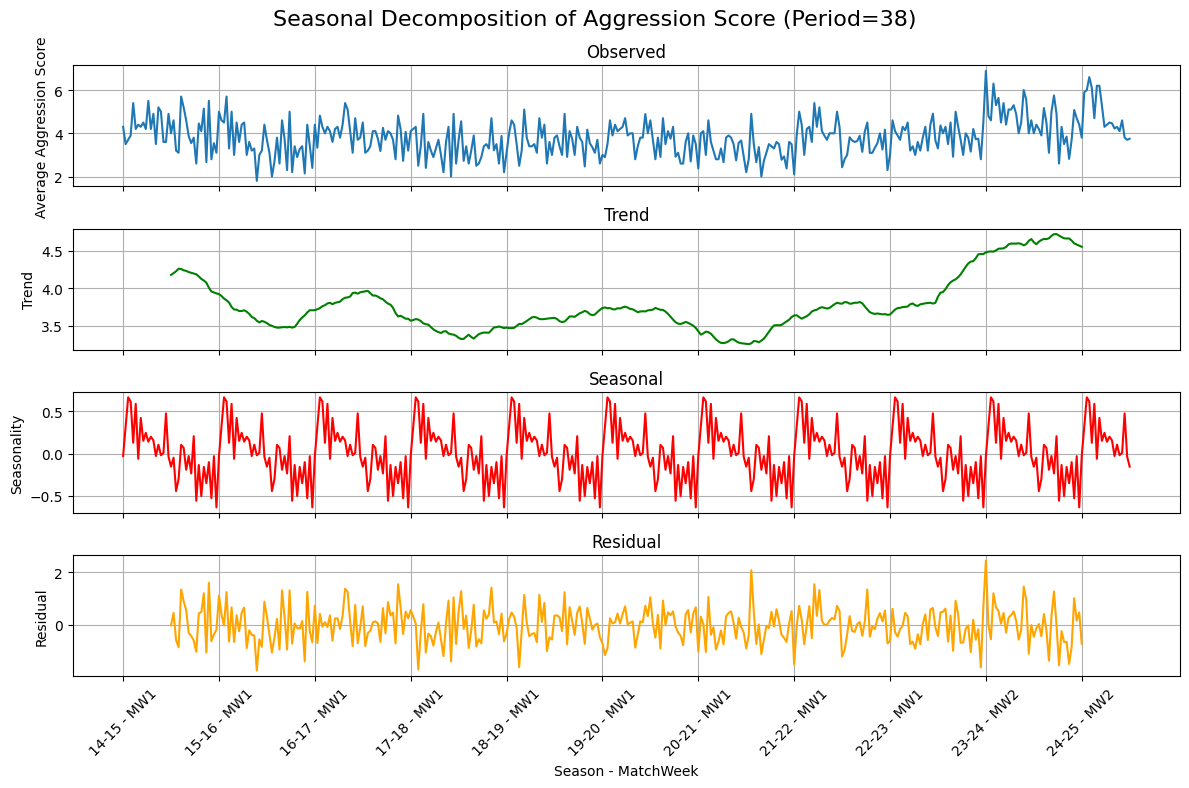

In [39]:
df_agg = df.groupby(['Season', 'MatchWeek'])['AggressionScore'].mean().reset_index()


df_agg['season_week'] = (
    df_agg['Season'].str.slice(2, 4) + '-' + df_agg['Season'].str.slice(7, 9)
    + ' - MW' + df_agg['MatchWeek'].astype(str)
)
df_agg['time_idx'] = range(len(df_agg))
df_agg.set_index('time_idx', inplace=True)

result = seasonal_decompose(df_agg['AggressionScore'], model='additive', period=38)

fig, axs = plt.subplots(4, 1, figsize=(12, 8), sharex=True)

axs[0].plot(df_agg['season_week'], result.observed, )
axs[0].set_title('Observed')
axs[0].set_ylabel('Average Aggression Score')
axs[0].grid(True)

axs[1].plot(df_agg['season_week'], result.trend, color = 'green')
axs[1].set_title('Trend')
axs[1].set_ylabel('Trend')
axs[1].grid(True)

axs[2].plot(df_agg['season_week'], result.seasonal, color = 'red')
axs[2].set_title('Seasonal')
axs[2].set_ylabel('Seasonality')
axs[2].grid(True)

axs[3].plot(df_agg['season_week'], result.resid, color = 'orange')
axs[3].set_title('Residual')
axs[3].set_ylabel('Residual')
axs[3].set_xlabel('Season - MatchWeek')
axs[3].grid(True)



xticks = df_agg['season_week'].iloc[::38]
xtick_pos = range(0, len(df_agg), 38)
axs[3].set_xticks(xtick_pos)
axs[3].set_xticklabels(xticks, rotation=45)

fig.suptitle('Seasonal Decomposition of Aggression Score (Period=38)', fontsize=16)

plt.tight_layout()
plt.show()


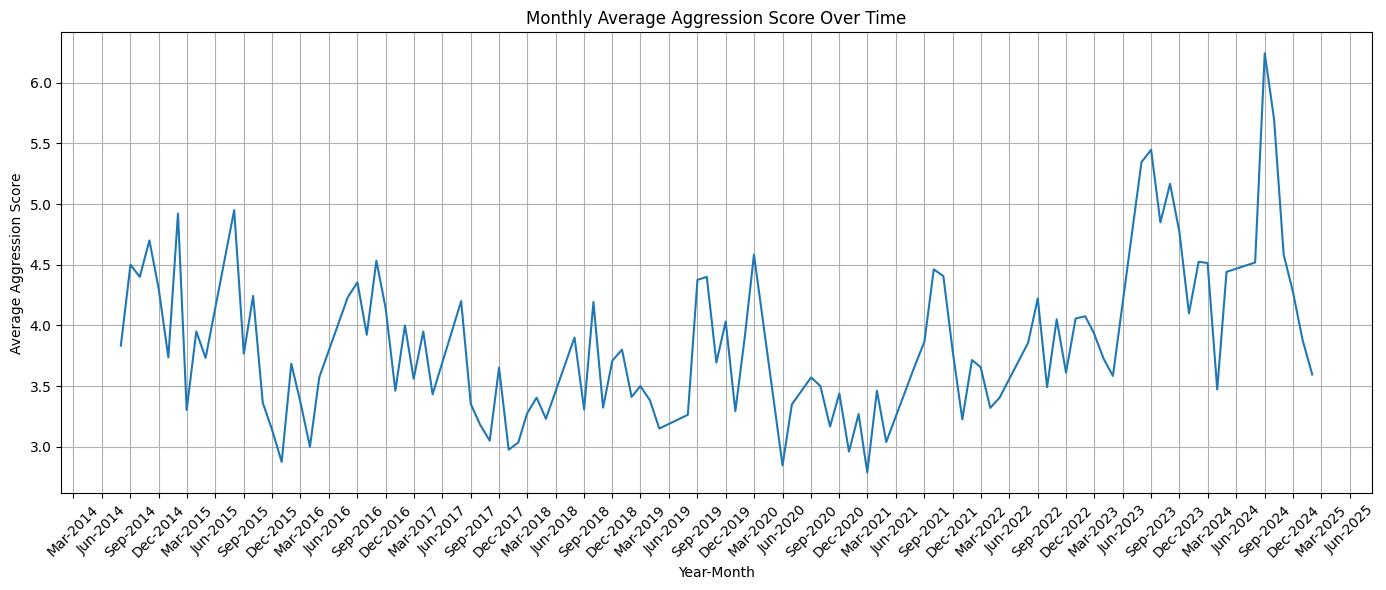

In [40]:
df['Date'] = pd.to_datetime(df['Date'])

df_months = df.copy()
df_months['YearMonth'] = df_months['Date'].dt.to_period('M').dt.to_timestamp()

monthly_avg = df_months.groupby('YearMonth')['AggressionScore'].mean().reset_index()

plt.figure(figsize=(14, 6))
sns.lineplot(data=monthly_avg, x='YearMonth', y='AggressionScore')
plt.title('Monthly Average Aggression Score Over Time')
plt.xlabel('Year-Month')
plt.ylabel('Average Aggression Score')

plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b-%Y'))
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=3))
plt.xticks(rotation=45)

plt.grid(True)
plt.tight_layout()
plt.show()

examine the average aggression index for whole season

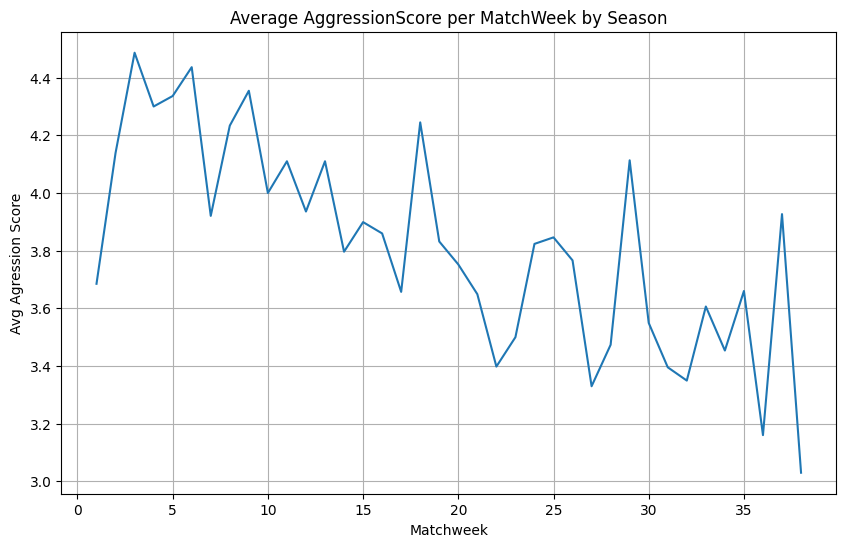

In [41]:
df_grouped_MmatchWeek = df.groupby(['MatchWeek'])[['AggressionScore']].mean().reset_index()

plt.figure(figsize=(10, 6))
sns.lineplot(data=df_grouped_MmatchWeek, x='MatchWeek', y='AggressionScore')
plt.title('Average AggressionScore per MatchWeek by Season')
plt.ylabel('Avg Agression Score')
plt.xlabel('Matchweek')
plt.grid(True)
plt.show()

# Part 2 - Methods

In [4]:
df = pd.read_csv('premier_league_final3.csv')

## Model 1 - SARIMA

In [5]:
df_agg = (
    df.groupby(['Season', 'MatchWeek'])['AggressionScore']
      .mean()
      .reset_index()
)

df_agg['season_week'] = df_agg['Season'].astype(str) + ' - MW' + df_agg['MatchWeek'].astype(str)

df_agg['idx'] = range(len(df_agg))
df_agg.set_index('idx', inplace=True)

y_orig = df_agg['AggressionScore']

y_diff  = y_orig.diff().dropna()
y_seas  = y_diff.diff(38).dropna()

ACF & PACF

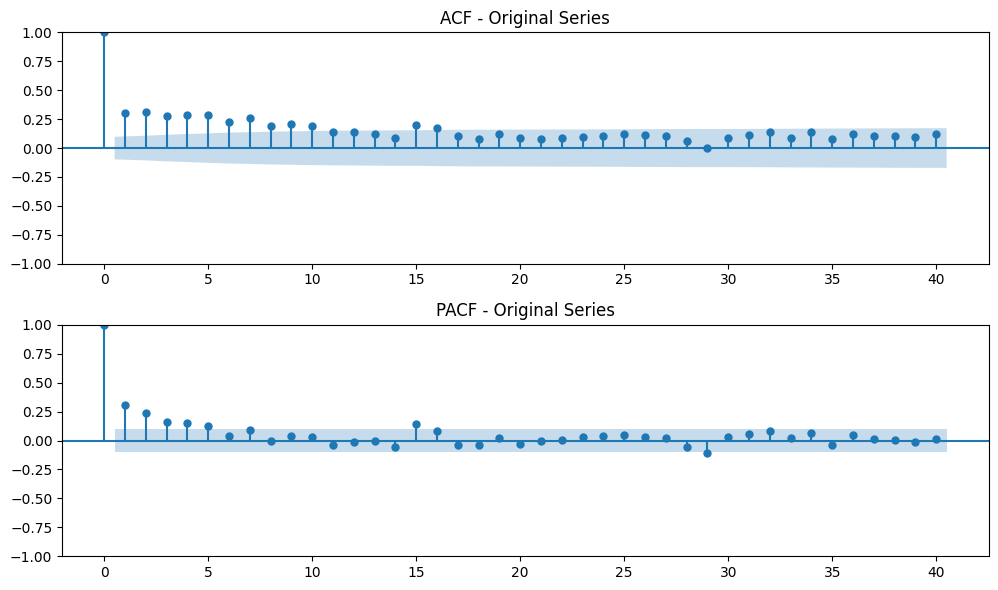

In [7]:
fig, ax = plt.subplots(2, 1, figsize=(10, 6))
plot_acf(y_orig.dropna(), lags=40, ax=ax[0])
ax[0].set_title('ACF - Original Series')
plot_pacf(y_orig.dropna(), lags=40, ax=ax[1])
ax[1].set_title('PACF - Original Series')
plt.tight_layout()
plt.show()

Plot ACF and PACF for seasonally differenced series


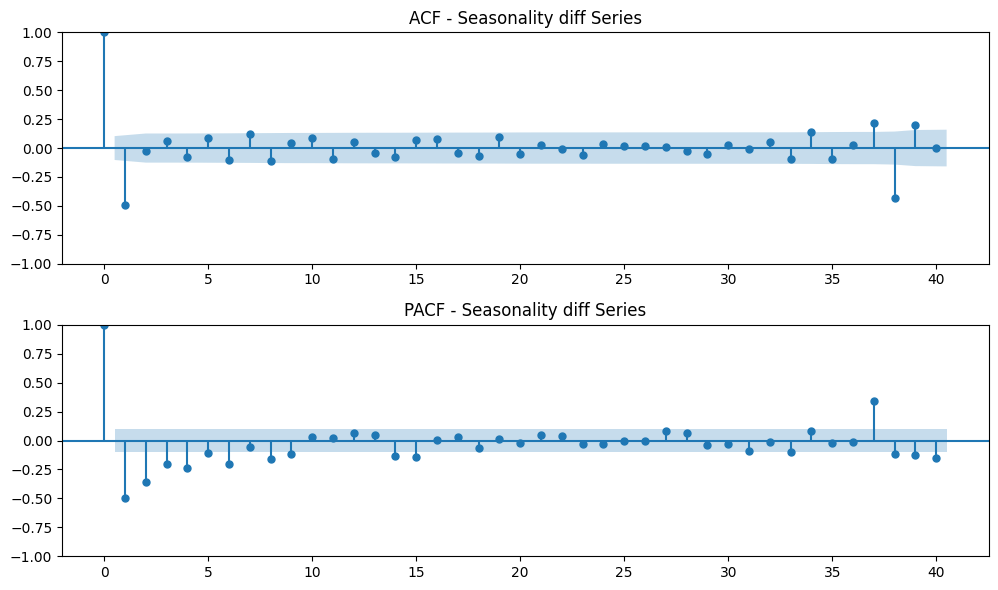

In [8]:
fig, ax = plt.subplots(2, 1, figsize=(10, 6))
plot_acf(y_seas.dropna(), lags=40, ax=ax[0])
ax[0].set_title('ACF - Seasonality diff Series')
plot_pacf(y_seas.dropna(), lags=40, ax=ax[1])
ax[1].set_title('PACF - Seasonality diff Series')
plt.tight_layout()
plt.show()

In [9]:
adf_orig = adfuller(y_orig.dropna())

orig_adf_results = {
    'ADF Statistic': adf_orig[0],
    'p-value': adf_orig[1],
    'Used Lag': adf_orig[2],
    'Observations': adf_orig[3],
    'Critical Values': adf_orig[4],
    'Conclusion': 'Non-stationary' if adf_orig[1] > 0.05 else 'Stationary'
}

In [10]:
adf_seas = adfuller(y_seas.dropna())

seas_adf_results = {
    'ADF Statistic': adf_seas[0],
    'p-value': adf_seas[1],
    'Used Lag': adf_seas[2],
    'Observations': adf_seas[3],
    'Critical Values': adf_seas[4],
    'Conclusion': 'Non-stationary' if adf_seas[1] > 0.05 else 'Stationary'
}

In [11]:
orig_res_adf = pd.DataFrame(orig_adf_results)
seas_res_adf = pd.DataFrame(seas_adf_results)

In [12]:
print("ADF results for Original time series:")
display(orig_res_adf)
print("ADF results for Seasonal time series:")
display(seas_res_adf)

ADF results for Original time series:


,ADF Statistic,p-value,Used Lag,Observations,Critical Values,Conclusion
1%,-4.037788,0.001225,6,393,-3.447099,Stationary
5%,-4.037788,0.001225,6,393,-2.868923,Stationary
10%,-4.037788,0.001225,6,393,-2.570703,Stationary


ADF results for Seasonal time series:


,ADF Statistic,p-value,Used Lag,Observations,Critical Values,Conclusion
1%,-7.640258,1.904249e-11,14,346,-3.449392,Stationary
5%,-7.640258,1.904249e-11,14,346,-2.869930,Stationary
10%,-7.640258,1.904249e-11,14,346,-2.571240,Stationary


after the diff manual model for lowest bic

In [13]:
train_size = int(0.8 * len(df_agg))
train = df_agg.iloc[:train_size]
test = df_agg.iloc[train_size:]

SARIMA model

In [15]:
def sarimax_model_and_evaluate(model,phase,test,to_plot=False):

  results = model.fit(disp=False)

  forecast = results.get_forecast(steps=80)
  forecast_mean = forecast.predicted_mean
  conf_int = forecast.conf_int()
  bic_value = results.bic

  true_values = test['AggressionScore'].values
  rmse = np.sqrt(mean_squared_error(true_values, forecast_mean))

  if to_plot == True:
    plt.figure(figsize=(16, 6))
    plt.plot(df_agg['season_week'], df_agg['AggressionScore'], label='Observed', color='blue')
    plt.plot(df_agg['season_week'].iloc[train_size:], forecast_mean, label='Forecast', color='red')
    plt.fill_between(df_agg['season_week'].iloc[train_size:], conf_int.iloc[:, 0], conf_int.iloc[:, 1],
                    color='red', alpha=0.2)

    xticks = df_agg['season_week'].iloc[::19]
    xtick_positions = range(0, len(df_agg), 19)
    plt.xticks(ticks=xtick_positions, labels=xticks, rotation=45)
    plt.title(f'SARIMA Forecast {phase} - Aggression Score by Matchweek and Season')
    plt.xlabel('Season - MatchWeek')
    plt.ylabel('Aggression Score')
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()


  return bic_value, rmse

fine tune the parameters we want to examine

In [35]:
p = [0, 1]
d = 1
q = [2, 3, 4]

P = 1
D = 1
Q = 1
s = 38

best_bic = np.inf
best_order = None

for order in itertools.product(p, q):
  model = SARIMAX(train['AggressionScore'], order=(order[0], d, order[1]), seasonal_order=(P, D, Q, s))
  bic, rmse = sarimax_model_and_evaluate(model,"Seasonal",test)
  if bic < best_bic:
    best_bic   = bic
    best_order = order
    list_best_order = list(best_order)
    list_best_order.insert(1,d)

print(f'\n*** chosen: SARIMA({list_best_order}),({P},{D},{Q},{s})  ,  BIC={best_bic:0.4f}')

(0, 2)
724.847954162401
(0, 3)
730.4801879217698


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


(0, 4)
735.8511566451747
(1, 2)
730.4723355805975
(1, 3)
735.8018294533025
(1, 4)
740.9861028269936

*** chosen: SARIMA([0, 1, 2]),(1,1,1,38)  ,  BIC=724.8480


comparison the original model to the seasonal model

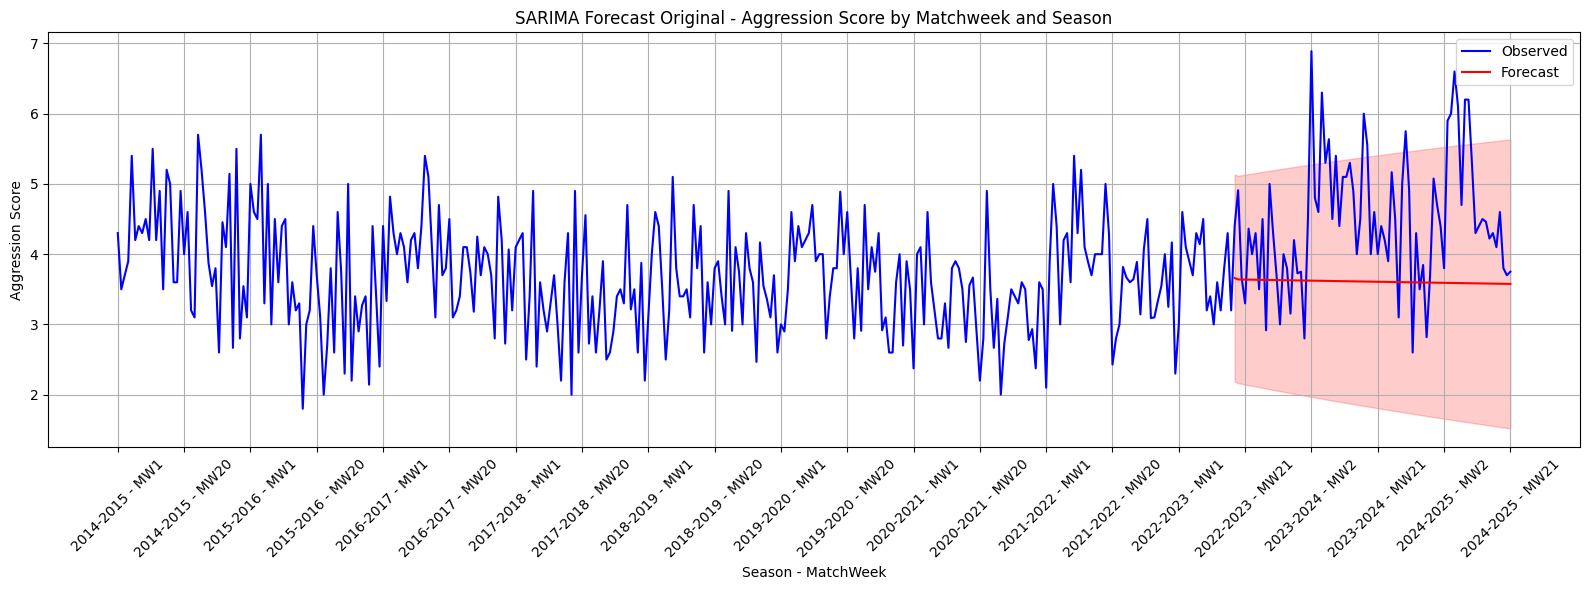

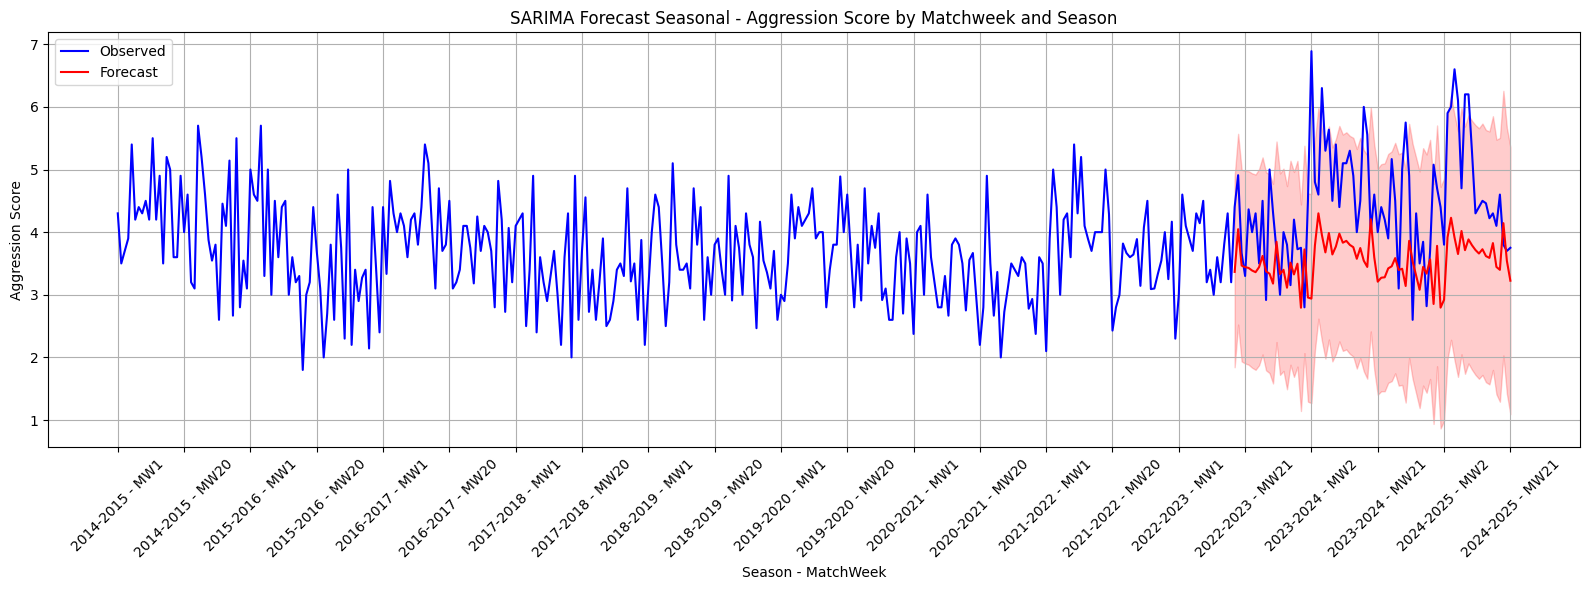

In [32]:
model_orig = SARIMAX(train['AggressionScore'], order=(1, 0, 2), seasonal_order=(0, 0, 0, s))
model_seasonal = SARIMAX(train['AggressionScore'], order=(best_order[0], d, best_order[1]), seasonal_order=(P, D, Q, s))

bic_orig, rmse_orig = sarimax_model_and_evaluate(model_orig,"Original",test,True)
bic_seasonal, rmse_seasonal = sarimax_model_and_evaluate(model_seasonal,"Seasonal",test,True)

In [33]:
print(f'Original BIC: {bic_orig:.4f}')
print(f'Seasonal BIC: {bic_seasonal:.4f}')

Original BIC: 752.7375
Seasonal BIC: 724.8480


In [34]:
print(f"RMSE for best sarima model: {rmse_seasonal:.4f}")

RMSE for best sarima model: 1.2930


## Model 2 - Prophet

In [86]:
df_agg = df.groupby(['Season', 'MatchWeek'])['AggressionScore'].mean().reset_index()
df_agg = df_agg.sort_values(['Season', 'MatchWeek']).reset_index(drop=True)

df_agg['ds'] = pd.date_range(start='2000-08-01', periods=len(df_agg), freq='W')
df_agg['y'] = df_agg['AggressionScore']

# Boxing day dates
years = range(2014, 2025)
boxing_days = [pd.Timestamp(f"{year}-12-{day}") for year in years for day in [26, 27, 28]]
boxing_df = pd.DataFrame({'holiday': 'boxing_day_matchweek', 'ds': boxing_days})

df_agg['label'] = df_agg['Season'].astype(str) + ' - MW' + df_agg['MatchWeek'].astype(str)

train = df_agg.iloc[:-80].copy()
test = df_agg.iloc[-80:].copy()

hyperparameters finetuning

In [87]:

import logging

for logger_name in ['prophet', 'cmdstanpy']:
    logging.getLogger(logger_name).setLevel(logging.CRITICAL)

param_check = {
    'changepoint_prior_scale': [0.01, 0.05, 0.1],
    'seasonality_mode': ['additive', 'multiplicative'],
    'fourier_order': [5, 10],
    'seasonality_prior_scale': [1.0, 10.0],
    'holidays_prior_scale': [1.0, 10.0],
    'changepoint_range': [0.8]
}

all_params = [dict(zip(param_check.keys(), v)) for v in itertools.product(*param_grid.values())]

results = []

for params in all_params:
    model = Prophet(
        growth='linear',
        changepoint_prior_scale=params['changepoint_prior_scale'],
        seasonality_mode=params['seasonality_mode'],
        seasonality_prior_scale=params['seasonality_prior_scale'],
        holidays_prior_scale=params['holidays_prior_scale'],
        changepoint_range=params['changepoint_range'],
        daily_seasonality=False,
        weekly_seasonality=False,
        yearly_seasonality=False,
        holidays=boxing_df
    )

    model.add_seasonality(name='football_season', period=38, fourier_order=params['fourier_order'])
    model.fit(train[['ds', 'y']])

    future = model.make_future_dataframe(periods=80, freq='W')
    forecast = model.predict(future)

    forecast_test = forecast.set_index('ds').loc[test['ds']].reset_index()
    rmse = np.sqrt(mean_squared_error(test['y'], forecast_test['yhat']))

    results.append({
        'params': params,
        'rmse': rmse
    })

results_sorted = sorted(results, key=lambda x: x['rmse'])
best_model = results_sorted[0]

In [88]:
for p in best_model['params']:
  print(f"{p}={best_model['params'][p]},")

changepoint_prior_scale=0.1,
seasonality_mode=additive,
fourier_order=5,
seasonality_prior_scale=1.0,
holidays_prior_scale=1.0,
changepoint_range=0.8,


run the and plot the best model

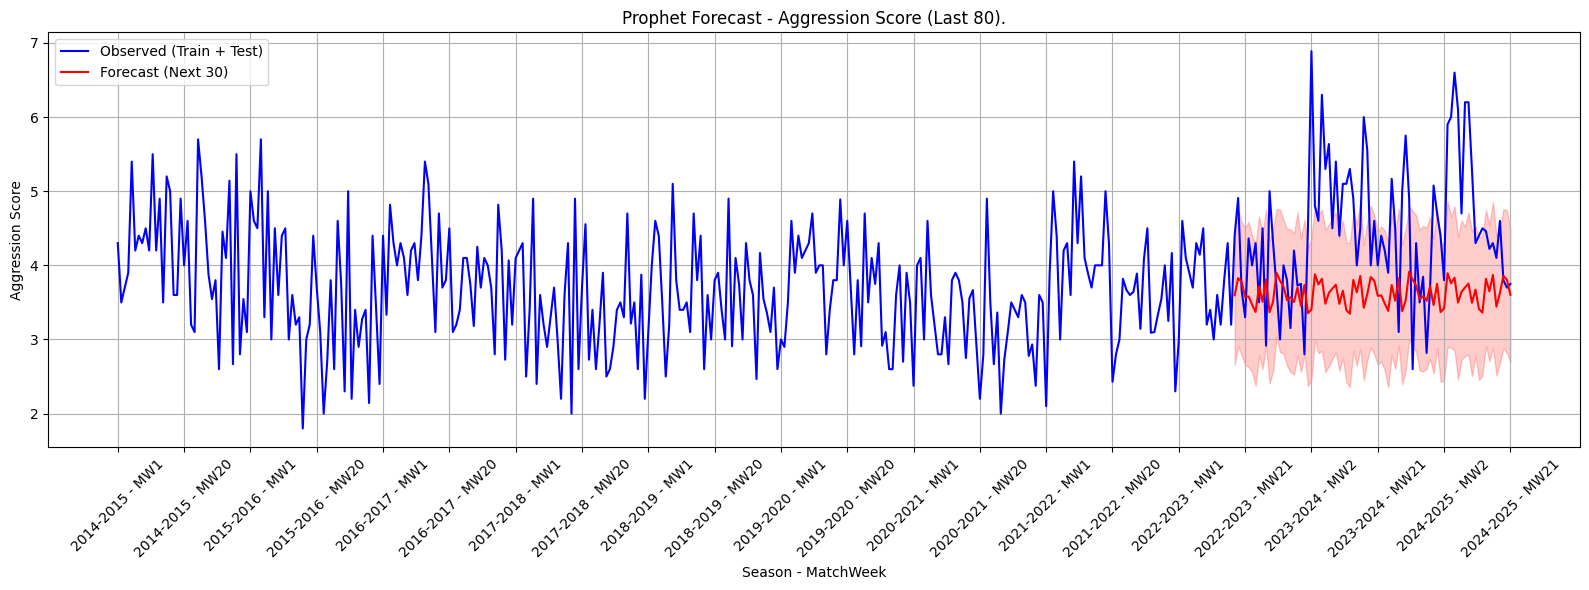

In [90]:
model = Prophet(
    holidays=boxing_df,
    daily_seasonality=False,
    weekly_seasonality=False,
    yearly_seasonality=False,
    changepoint_prior_scale=0.1,
    seasonality_mode='additive',
    holidays_prior_scale=1.0,
    changepoint_range=0.8
)
model.add_seasonality(name='football_season', period=38, fourier_order=5, prior_scale=10.0)
model.fit(train[['ds', 'y']])

future = model.make_future_dataframe(periods=80, freq='W')
forecast = model.predict(future)

forecast_test = forecast.iloc[-80:].copy()
forecast_test['label'] = test['label'].values

plt.figure(figsize=(16, 6))
plt.plot(df_agg['ds'], df_agg['y'], label='Observed (Train + Test)', color='blue')
plt.plot(forecast_test['ds'], forecast_test['yhat'], label='Forecast (Next 30)', color='red')
plt.fill_between(forecast_test['ds'], forecast_test['yhat_lower'], forecast_test['yhat_upper'], color='red', alpha=0.2)

xtick_idx = df_agg.index[::19]
plt.xticks(ticks=df_agg['ds'].iloc[xtick_idx], labels=df_agg['label'].iloc[xtick_idx], rotation=45)


plt.title(f'Prophet Forecast - Aggression Score (Last 80).')
plt.xlabel('Season - MatchWeek')
plt.ylabel('Aggression Score')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


In [91]:
print(f"RMSE Prophet: {best_model['rmse']:.4f}")

RMSE Prophet: 1.2815


## Model 3 - LSTM

data prep

In [93]:
df = pd.read_csv('premier_league_final3.csv')
df['Date'] = pd.to_datetime(df['Date'])

df_agg = (
    df.groupby(['Season', 'MatchWeek'], as_index=False)
    .agg({
        'Date': 'mean',
        'AggressionScore': 'mean',
    })
)

df_agg['ID'] = df_agg['Season'].astype(str) + ' - MW' + df_agg['MatchWeek'].astype(str)

df_agg = df_agg.sort_values(['Season','MatchWeek']).reset_index(drop=True)

In [94]:
label_all = df_agg['Season'].astype(str) + ' - MW' + df_agg['MatchWeek'].astype(str)
label_all = label_all.tolist()

In [95]:
df_agg = df_agg.set_index('ID')
df_agg.drop(columns=["Season","MatchWeek", "Date"],inplace=True)

In [96]:
scaler = MinMaxScaler()
df_agg['scaled_score'] = scaler.fit_transform(df_agg[['AggressionScore']])

In [97]:
df_agg.drop(columns=["AggressionScore"],inplace=True)

In [98]:
df_agg.head()

,scaled_score
ID,
2014-2015 - MW1,0.491266
2014-2015 - MW2,0.334061
2014-2015 - MW3,0.373362
2014-2015 - MW4,0.412664
2014-2015 - MW5,0.707424


In [99]:
def create_sequences(data, labels, seq_length):
    xs, ys, lbls = [], [], []
    for i in range(len(data) - seq_length):
        x = data[i:i+seq_length]
        y = data[i+seq_length]
        lbl = labels[i+seq_length]
        xs.append(x)
        ys.append(y)
        lbls.append(lbl)
    return np.array(xs), np.array(ys), np.array(lbls)

Train Test Split

In [100]:
def create_train_test(df_agg, seq_len):
  X, y, label_seq = create_sequences(df_agg['scaled_score'].values, df_agg.index.values, seq_len)

  split = int(len(X) * 0.8)
  X_train, X_test = X[:split], X[split:]
  y_train, y_test = y[:split], y[split:]

  X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
  X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

  X_train = torch.tensor(X_train, dtype=torch.float32)
  y_train = torch.tensor(y_train, dtype=torch.float32)
  X_test = torch.tensor(X_test, dtype=torch.float32)
  y_test = torch.tensor(y_test, dtype=torch.float32)

  return X_train, X_test, y_train, y_test

In [101]:
class AggressionDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

LSTM Model

In [102]:
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, intermediate_size, output_size):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, batch_first=True)
        self.hidden_fc = nn.Linear(hidden_size, intermediate_size)
        self.relu = nn.ReLU()
        self.output_fc = nn.Linear(intermediate_size, output_size)

    def forward(self, x):
        out, _ = self.lstm(x)
        out = out[:, -1, :]  # Take last time step
        out = self.hidden_fc(out)
        out = self.relu(out)
        out = self.output_fc(out)
        return out

Training Loop

In [103]:
def training_model(model,train_loader,optimizer,criterion):

  device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

  EPOCHS = 150
  for epoch in range(EPOCHS):
      model.train()
      for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)
        optimizer.zero_grad()
        output = model(xb).squeeze()
        loss = criterion(output, yb)
        loss.backward()
        optimizer.step()
      if (epoch + 1) % 10 == 0:
          print(f"Epoch {epoch+1}/{EPOCHS}, Loss: {loss.item():.4f}")

  return model

Evaluation

In [104]:
def evaluate_model(model,X_test,y_test,scaler):

  model.eval()
  with torch.no_grad():
      predictions = model(X_test).squeeze().cpu().numpy()

      y_test_inv = scaler.inverse_transform(y_test.cpu().numpy().reshape(-1, 1))
      preds_inv = scaler.inverse_transform(predictions.reshape(-1, 1))


      mse = mean_squared_error(y_test_inv, preds_inv)
      rmse = np.sqrt(mse)

      return mse,rmse,y_test_inv,preds_inv

fine tune preperations

In [ ]:

mse_values = []
rmse_values = []


check_params = {
    'sequence_length': [3, 4, 5, 6, 7, 8, 9, 10],
    'hidden_size': [32, 64],
    'intermediate_size': [16, 32],
    'learning_rate': [0.002, 0.001, 0.0005],
    'optimizer': ['adam', 'sgd'],
    'criterion': ['mse', 'mae']
}
param_combinations = list(product(*check_params.values()))


results = []
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
for combo in tqdm(param_combinations):
  params = dict(zip(check_params.keys(), combo))
  seq_len = params['sequence_length']
  X_train, X_test, y_train, y_test = create_train_test(df_agg, seq_len)
  model = LSTMModel(input_size=1, hidden_size=params['hidden_size'],intermediate_size=params['intermediate_size'],output_size=1).to(device)

  train_loader = DataLoader(AggressionDataset(X_train, y_train), batch_size=32, shuffle=True)
  test_loader = DataLoader(AggressionDataset(X_test, y_test), batch_size=32, shuffle=False)

  criterion = nn.MSELoss() if params['criterion'] == 'mse' else nn.L1Loss()

  if params['optimizer'] == 'adam':
    optimizer = optim.Adam(model.parameters(), lr=params['learning_rate'])
  else:
    optimizer = optim.SGD(model.parameters(), lr=params['learning_rate'])

  X_train = X_train.unsqueeze(-1).to(device)
  X_test = X_test.to(device)
  y_train = y_train.to(device)
  y_test = y_test.to(device)


  model = training_model(model, train_loader=train_loader,optimizer=optimizer, criterion=criterion, device=device)


  mse, rmse,_,_ = evaluate_model(model, X_test.to(device), y_test.to(device), scaler)

  results.append({
      'sequence_length': seq_len,
      'hidden_size': params['hidden_size'],
      'intermediate_size': params['intermediate_size'],
      'learning_rate': params['learning_rate'],
      'optimizer': params['optimizer'],
      'criterion': params['criterion'],
      'mse': mse,
      'rmse': rmse
  })



In [ ]:
results_df = pd.DataFrame(results)
results_df = results_df.sort_values('rmse')
results_df.to_csv("grid_search_lstm_results.csv", index=False)
results_df.head()

Best model running

In [105]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
best_seq_len = 6
best_hidden_size = 32
best_intermediate_size = 32
best_learning_rate = 0.002

best_model = LSTMModel(input_size=1, hidden_size=best_hidden_size,intermediate_size=best_hidden_size,output_size=1).to(device)

best_optimizer = optim.Adam(best_model.parameters(), lr=best_learning_rate)
best_criterion = nn.MSELoss()

In [106]:
X_train, X_test, y_train, y_test = create_train_test(df_agg, best_seq_len)

train_loader = DataLoader(AggressionDataset(X_train, y_train), batch_size=32, shuffle=True)
test_loader = DataLoader(AggressionDataset(X_test, y_test), batch_size=32, shuffle=False)

X_train = X_train.unsqueeze(-1).to(device)
X_test = X_test.to(device)
y_train = y_train.to(device)
y_test = y_test.to(device)

<ipython-input-101-548cac1994e4>:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.X = torch.tensor(X, dtype=torch.float32)
<ipython-input-101-548cac1994e4>:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.y = torch.tensor(y, dtype=torch.float32)


In [109]:
best_model = training_model(best_model, train_loader=train_loader,optimizer=best_optimizer, criterion=best_criterion)

mse, rmse, y_test_inv, pred_inv = evaluate_model(best_model, X_test.to(device), y_test.to(device),scaler)

Epoch 10/150, Loss: 0.0167
Epoch 20/150, Loss: 0.0216
Epoch 30/150, Loss: 0.0214
Epoch 40/150, Loss: 0.0127
Epoch 50/150, Loss: 0.0176
Epoch 60/150, Loss: 0.0272
Epoch 70/150, Loss: 0.0216
Epoch 80/150, Loss: 0.0271
Epoch 90/150, Loss: 0.0227
Epoch 100/150, Loss: 0.0176
Epoch 110/150, Loss: 0.0200
Epoch 120/150, Loss: 0.0177
Epoch 130/150, Loss: 0.0113
Epoch 140/150, Loss: 0.0120
Epoch 150/150, Loss: 0.0283


Forcast Plotting

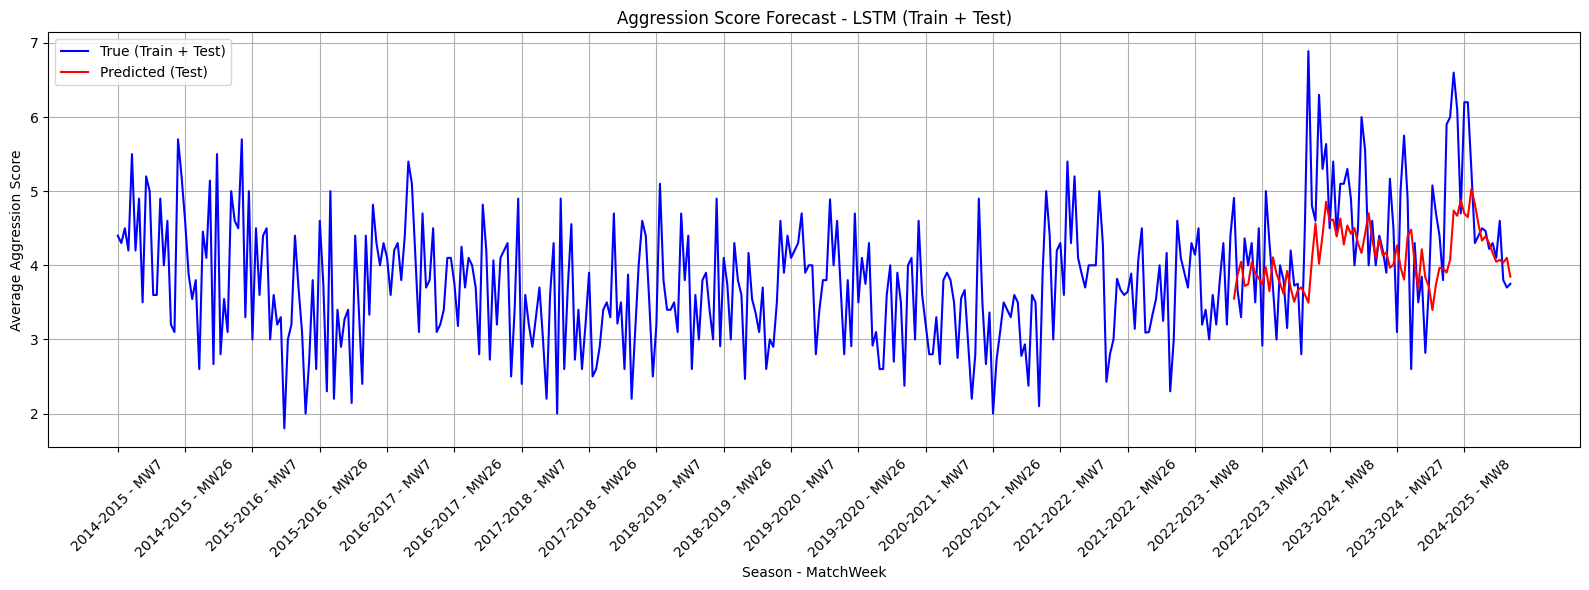

In [111]:
y_all = torch.cat((y_train, y_test), dim=0).cpu().numpy()
true_vals = scaler.inverse_transform(y_all.reshape(-1, 1))

label_all = label_all[-len(true_vals):]
label_test = label_all[-len(pred_inv):]


plt.figure(figsize=(16, 6))
plt.plot(label_all,true_vals , label='True (Train + Test)', color='blue')
plt.plot(label_test, pred_inv, label='Predicted (Test)', color='red')

tick_locs = np.arange(0, len(label_all), 19)
plt.xticks(ticks=tick_locs, labels=[label_all[i] for i in tick_locs], rotation=45)

plt.title('Aggression Score Forecast - LSTM (Train + Test)')
plt.xlabel('Season - MatchWeek')
plt.ylabel('Average Aggression Score')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

RMSE Value

In [112]:
print(f" RMSE Value is: {rmse:.4f}")

 RMSE Value is: 0.9518


# Part 3 - Exogenous Features

In [68]:
df = pd.read_csv('premier_league_final3.csv')
df['Date'] = pd.to_datetime(df['Date'])

df_agg_exog = (
    df.groupby(['Season', 'MatchWeek'], as_index=False)
    .agg({
        'Date': 'mean',
        'AggressionScore': 'mean',
        'last_3_avg_ref_aggression': 'mean'

    }).reset_index()
)
df_agg_exog['ID'] = df_agg_exog['Season'].astype(str) + ' - MW' + df_agg_exog['MatchWeek'].astype(str)
df_agg_exog = df_agg_exog.sort_values(['Season', 'MatchWeek']).reset_index(drop=True)

Graph for Last 3 Avg Ref Aggression

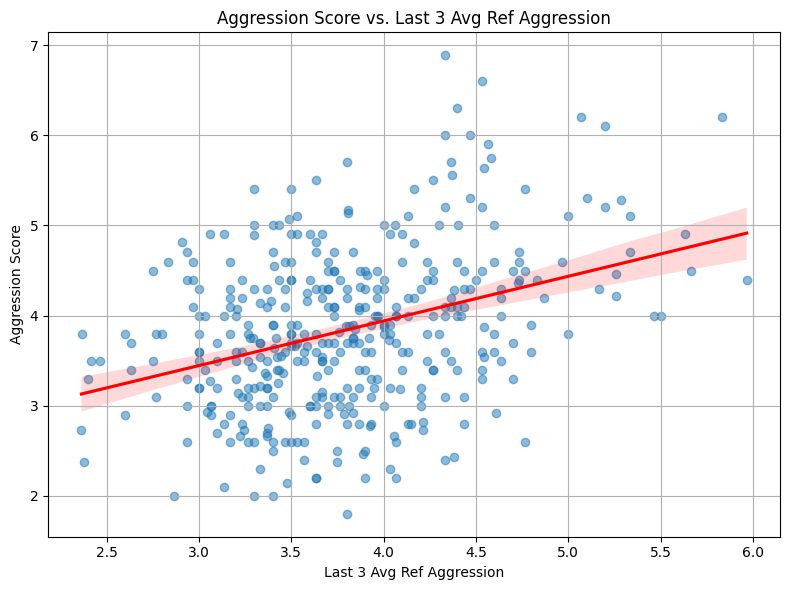

In [43]:
plt.figure(figsize=(8, 6))
sns.regplot(
    data=df_agg_exog,
    x='last_3_avg_ref_aggression',
    y='AggressionScore',
    scatter_kws={'alpha': 0.5},
    line_kws={'color': 'red'}
)

plt.title("Aggression Score vs. Last 3 Avg Ref Aggression")
plt.xlabel("Last 3 Avg Ref Aggression")
plt.ylabel("Aggression Score")
plt.grid(True)
plt.tight_layout()
plt.show()

In [44]:
correlation = df_agg_exog['last_3_avg_ref_aggression'].corr(df_agg_exog['AggressionScore'])
print(f"Aggression score VS. last_3_avg_ref_aggression: {correlation:.4f}")

Aggression score VS. last_3_avg_ref_aggression: 0.3556


In [45]:
label_all_exog = df_agg_exog['ID'].tolist()

In [46]:
train_size = int(len(df_agg_exog) * 0.8)

train = df_agg_exog.iloc[:train_size].copy()
test = df_agg_exog.iloc[train_size:].copy()

exog_col = ['last_3_avg_ref_aggression']


exog_train = train[exog_col]
exog_test = test[exog_col]

y_train_exog = train['AggressionScore']
y_test_exog = test['AggressionScore']

In [47]:
train_exog = train[exog_col]
test_exog = test[exog_col]

## SARIMA Exogenous

In [48]:
model = SARIMAX(
    train['AggressionScore'],
    exog=exog_train,
    order=(0, 1, 2),
    seasonal_order=(1, 1, 1, 38)
)

In [49]:
results = model.fit(disp=False)

In [50]:
forecast = results.get_forecast(steps=len(test), exog=exog_test)

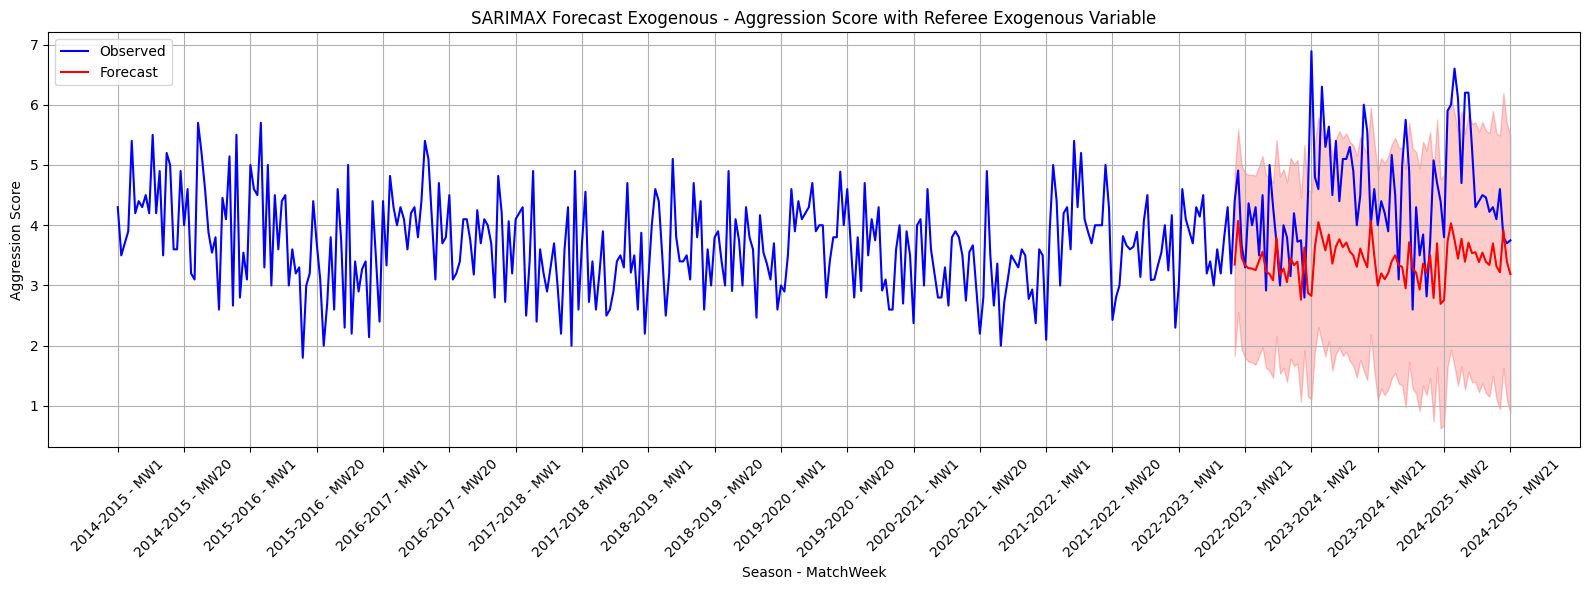

In [53]:
forecast_mean = forecast.predicted_mean
conf_int = forecast.conf_int()

plt.figure(figsize=(16, 6))
plt.plot(df_agg_exog['ID'], df_agg_exog['AggressionScore'], label='Observed', color='blue')
plt.plot(df_agg_exog['ID'].iloc[train_size:], forecast_mean, label='Forecast', color='red')
plt.fill_between(df_agg_exog['ID'].iloc[train_size:], conf_int.iloc[:, 0], conf_int.iloc[:, 1], color='red', alpha=0.2)

xticks = df_agg_exog['ID'].iloc[::19]
xtick_positions = range(0, len(df_agg_exog), 19)
plt.xticks(ticks=xtick_positions, labels=xticks, rotation=45)

plt.title(f'SARIMAX Forecast Exogenous - Aggression Score with Referee Exogenous Variable')
plt.xlabel('Season - MatchWeek')
plt.ylabel('Aggression Score')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

bic_value = results.bic
true_values = test['AggressionScore'].values
rmse = np.sqrt(mean_squared_error(true_values, forecast_mean))


In [52]:
print(f"RMSE: {rmse:.4f}")

RMSE: 1.4032


## Prophet Exogenous

Data preperaions for prophet model + Boxing day

In [54]:
df_agg_exog['ds'] = pd.date_range(start='2000-08-01', periods=len(df_agg_exog), freq='W')
df_agg_exog['y'] = df_agg_exog['AggressionScore']
df_agg_exog['label'] = df_agg_exog['Season'].astype(str) + ' - MW' + df_agg_exog['MatchWeek'].astype(str)

years = range(2014, 2025)
boxing_days = [pd.Timestamp(f"{year}-12-{day}") for year in years for day in [26, 27, 28]]
boxing_df = pd.DataFrame({'holiday': 'boxing_day_matchweek', 'ds': boxing_days})

Train test split with exogenous

In [55]:
train = df_agg_exog.iloc[:-80].copy()
test = df_agg_exog.iloc[-80:].copy()

 Model running

In [58]:
model = Prophet(
    holidays=boxing_df,
    daily_seasonality=False,
    weekly_seasonality=False,
    yearly_seasonality=False,
    changepoint_prior_scale=0.1,
    seasonality_mode='additive',
    holidays_prior_scale=1.0,
    changepoint_range=0.8
)

# add seasonality
model.add_seasonality(name='football_season', period=38, fourier_order=5, prior_scale=10.0)

model.fit(train[['ds', 'y'] + exog_col])
future = model.make_future_dataframe(periods=80, freq='W')
future = future.merge(df_agg_exog[['ds'] + exog_col], on='ds', how='left')

forecast = model.predict(future)

DEBUG:cmdstanpy:input tempfile: /tmp/tmpsqr0m8xz/fsipqare.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpsqr0m8xz/mj2utblo.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=95033', 'data', 'file=/tmp/tmpsqr0m8xz/fsipqare.json', 'init=/tmp/tmpsqr0m8xz/mj2utblo.json', 'output', 'file=/tmp/tmpsqr0m8xz/prophet_model2r_coskz/prophet_model-20250517180649.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:06:49 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:06:50 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Graph Plotting

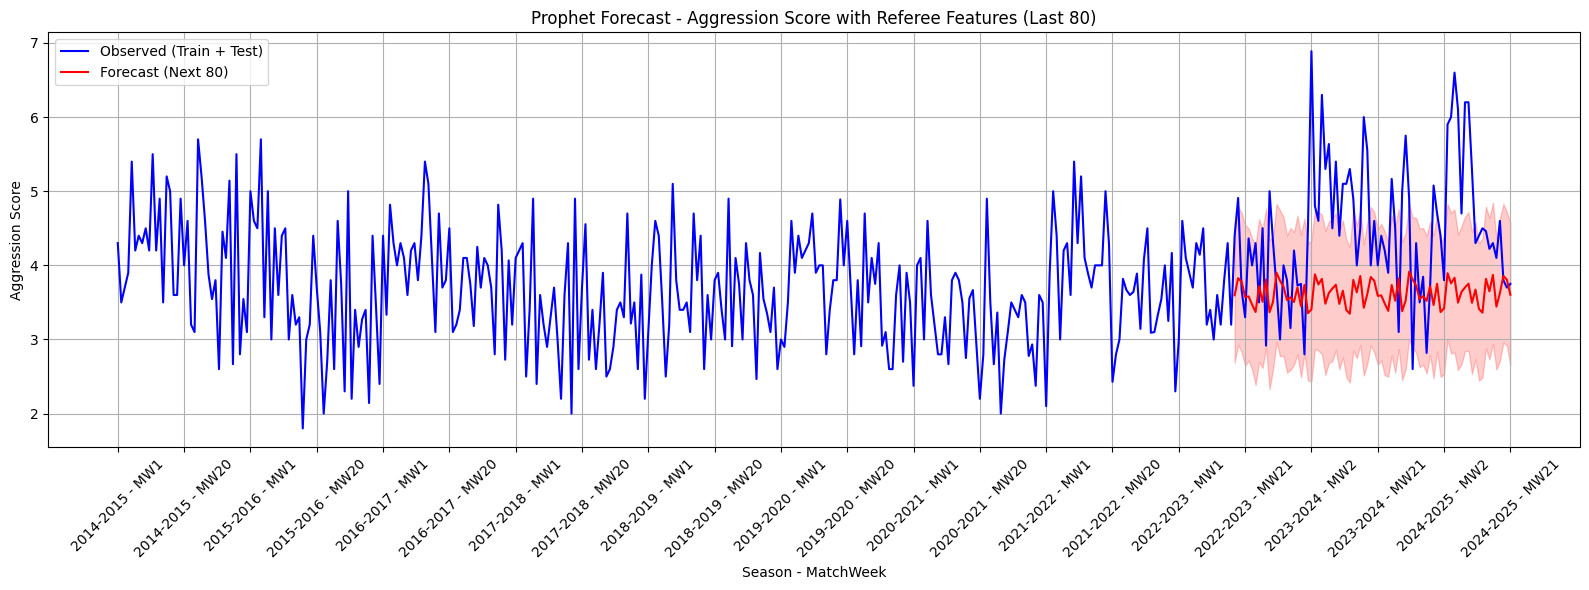

In [59]:
forecast_test = forecast.iloc[-80:].copy()
forecast_test['label'] = test['label'].values

plt.figure(figsize=(16, 6))
plt.plot(df_agg_exog['ds'], df_agg_exog['y'], label='Observed (Train + Test)', color='blue')
plt.plot(forecast_test['ds'], forecast_test['yhat'], label='Forecast (Next 80)', color='red')
plt.fill_between(forecast_test['ds'], forecast_test['yhat_lower'], forecast_test['yhat_upper'], color='red', alpha=0.2)

xtick_idx = df_agg_exog.index[::19]
plt.xticks(ticks=df_agg_exog['ds'].iloc[xtick_idx], labels=df_agg_exog['label'].iloc[xtick_idx], rotation=45)
plt.title(f'Prophet Forecast - Aggression Score with Referee Features (Last 80)')
plt.xlabel('Season - MatchWeek')
plt.ylabel('Aggression Score')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

RMSE Value

In [61]:
true_vals = test['y'].values
pred_vals = forecast_test['yhat'].values
rmse = np.sqrt(mean_squared_error(true_vals, pred_vals))
print(f"Test RMSE: {rmse:.4f}")

Test RMSE: 1.2817


## LSTM Exogenous

In [69]:
df_agg_exog_lstm = df_agg_exog.set_index('ID')
df_agg_exog_lstm = df_agg_exog_lstm[exog_col+['AggressionScore']]

In [70]:
# Target scaler
score_scaler = MinMaxScaler()
df_agg_exog_lstm['scaled_score'] = score_scaler.fit_transform(df_agg_exog_lstm[['AggressionScore']])

df_agg_exog_lstm.drop(columns=["AggressionScore"],inplace=True)

In [71]:
df_agg_exog_lstm.head()

,last_3_avg_ref_aggression,scaled_score
ID,,
2014-2015 - MW1,3.000000,0.491266
2014-2015 - MW2,3.266667,0.334061
2014-2015 - MW3,3.700000,0.373362
2014-2015 - MW4,3.933333,0.412664
2014-2015 - MW5,4.166667,0.707424


In [72]:
def create_sequences_exog(df, seq_length):
    target = df['scaled_score'].values
    exog = df.drop(columns=['scaled_score']).values
    X_seq, y_seq, exog_seq = [], [], []
    for i in range(len(target) - seq_length):
        X_seq.append(target[i:i+seq_length])
        y_seq.append(target[i+seq_length])
        exog_seq.append(exog[i+seq_length])
    X_combined = np.array([np.concatenate([x, e]) for x, e in zip(X_seq, exog_seq)])


    return np.array(X_combined), np.array(y_seq), np.array(exog_seq)

In [73]:
def create_train_test_exog(df, seq_len):
    X, y, exog = create_sequences_exog(df, seq_len)

    split = int(len(X) * 0.8)
    X_train, X_test = X[:split], X[split:]
    y_train, y_test = y[:split], y[split:]
    exog_train, exog_test = exog[:split], exog[split:]

    X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
    X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

    exog_train = torch.tensor(exog_train, dtype=torch.float32)
    exog_test = torch.tensor(exog_test, dtype=torch.float32)

    X_train = torch.tensor(X_train, dtype=torch.float32)
    y_train = torch.tensor(y_train, dtype=torch.float32)
    X_test = torch.tensor(X_test, dtype=torch.float32)
    y_test = torch.tensor(y_test, dtype=torch.float32)

    return X_train, X_test, exog_train, exog_test, y_train, y_test

In [80]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
seq_len = 6
hidden_size = 32
intermediate_size = 32
learning_rate = 0.002

model = LSTMModel(input_size=1, hidden_size=hidden_size,intermediate_size=intermediate_size,output_size=1).to(device)

optimizer = optim.Adam(model.parameters(), lr=learning_rate)
criterion = nn.MSELoss()

In [81]:
X_train_exog, X_test_exog,_,_, y_train_exog, y_test_exog = create_train_test_exog(df_agg_exog_lstm, seq_len)

train_loader = DataLoader(AggressionDataset(X_train_exog, y_train_exog), batch_size=32, shuffle=True)
test_loader = DataLoader(AggressionDataset(X_test_exog, y_test_exog), batch_size=32, shuffle=False)

X_train_exog = X_train_exog.unsqueeze(-1).to(device)
X_test_exog = X_test_exog.to(device)
y_train_exog = y_train_exog.to(device)
y_test_exog = y_test_exog.to(device)

<ipython-input-76-548cac1994e4>:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.X = torch.tensor(X, dtype=torch.float32)
<ipython-input-76-548cac1994e4>:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.y = torch.tensor(y, dtype=torch.float32)


In [82]:
model_exog = training_model(model, train_loader=train_loader,optimizer=optimizer, criterion=criterion)

mse_exog, rmse_exog, y_test_inv_exog, pred_inv_exog = evaluate_model(model_exog, X_test_exog.to(device), y_test_exog.to(device),score_scaler)

Epoch 10/150, Loss: 0.0208
Epoch 20/150, Loss: 0.0177
Epoch 30/150, Loss: 0.0232
Epoch 40/150, Loss: 0.0252
Epoch 50/150, Loss: 0.0180
Epoch 60/150, Loss: 0.0253
Epoch 70/150, Loss: 0.0247
Epoch 80/150, Loss: 0.0235
Epoch 90/150, Loss: 0.0262
Epoch 100/150, Loss: 0.0225
Epoch 110/150, Loss: 0.0252
Epoch 120/150, Loss: 0.0243
Epoch 130/150, Loss: 0.0223
Epoch 140/150, Loss: 0.0261
Epoch 150/150, Loss: 0.0210


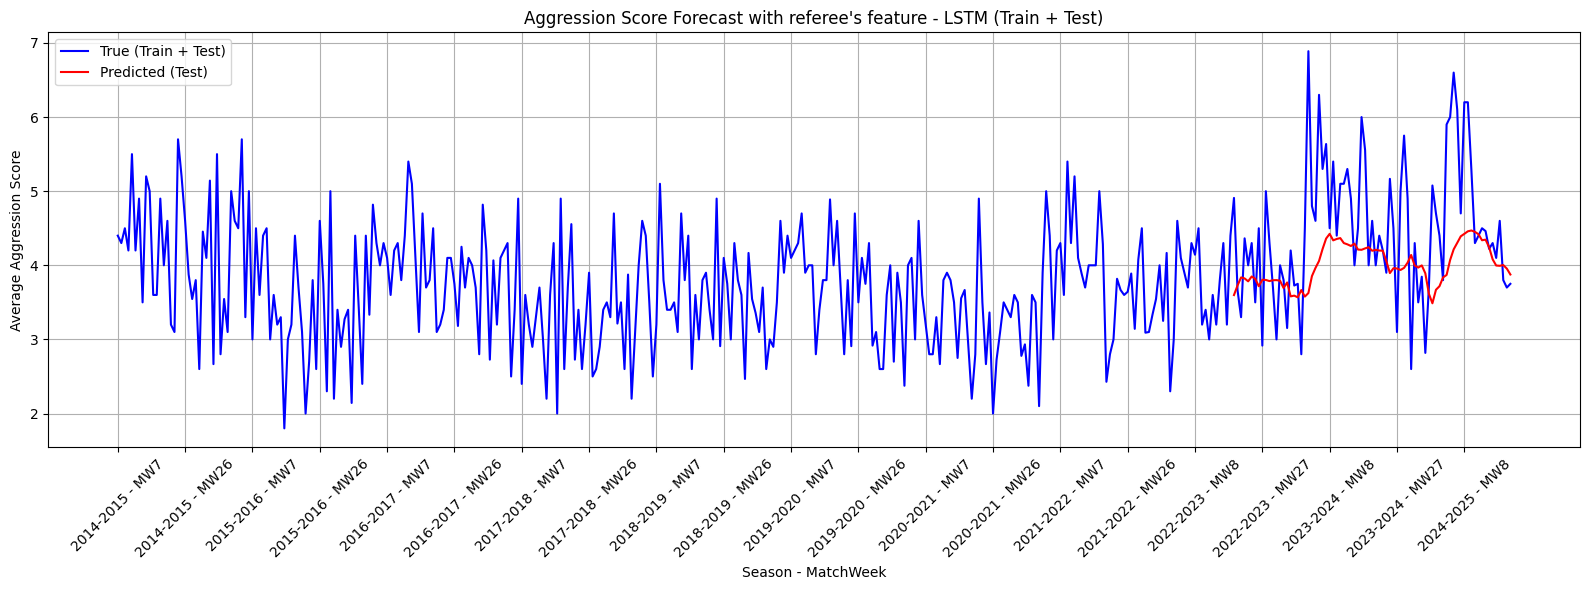

In [85]:
y_all_exog = torch.cat((y_train_exog, y_test_exog), dim=0).cpu().numpy()
true_vals_exog = score_scaler.inverse_transform(y_all_exog.reshape(-1, 1))

label_all_exog = label_all_exog[-len(true_vals_exog):]
label_test_exog = label_all_exog[-len(pred_inv_exog):]

plt.figure(figsize=(16, 6))
plt.plot(label_all_exog, true_vals_exog, label='True (Train + Test)', color='blue')
plt.plot(label_test_exog, pred_inv_exog, label='Predicted (Test)', color='red')

tick_locs = np.arange(0, len(label_all_exog), 19)
plt.xticks(ticks=tick_locs, labels=[label_all_exog[i] for i in tick_locs], rotation=45)

plt.title("Aggression Score Forecast with referee's feature - LSTM (Train + Test)")
plt.xlabel('Season - MatchWeek')
plt.ylabel('Average Aggression Score')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

In [84]:
print(f" RMSE Value is: {rmse_exog:.4f}")

 RMSE Value is: 0.9925


# Part 4 - Change Point Detection

In [ ]:
df = pd.read_csv('premier_league_final2.csv')
df['Date'] = pd.to_datetime(df['Date'])

df_agg = (
    df.groupby(['Season', 'MatchWeek'], as_index=False)
    .agg({
        'Date': 'mean',
        'AggressionScore': 'mean',
    })
)

df_agg['ID'] = df_agg['Season'].astype(str) + ' - MW' + df_agg['MatchWeek'].astype(str)

df_agg = df_agg.sort_values(['Season','MatchWeek']).reset_index(drop=True)

In [ ]:
df_agg.head()

,Season,MatchWeek,Date,AggressionScore,ID
0,2014-2015,1,2014-08-16 09:36:00,4.3,2014-2015 - MW1
1,2014-2015,2,2014-08-23 12:00:00,3.5,2014-2015 - MW2
2,2014-2015,3,2014-08-30 07:12:00,3.7,2014-2015 - MW3
3,2014-2015,4,2014-09-13 07:12:00,3.9,2014-2015 - MW4
4,2014-2015,5,2014-09-20 09:36:00,5.4,2014-2015 - MW5


PELT for change point detection

In [ ]:
signal = df_agg['AggressionScore'].values

model = "rbf"
algo = rpt.Pelt(model=model).fit(signal)

penalty_value = 3
result = algo.predict(pen=penalty_value)

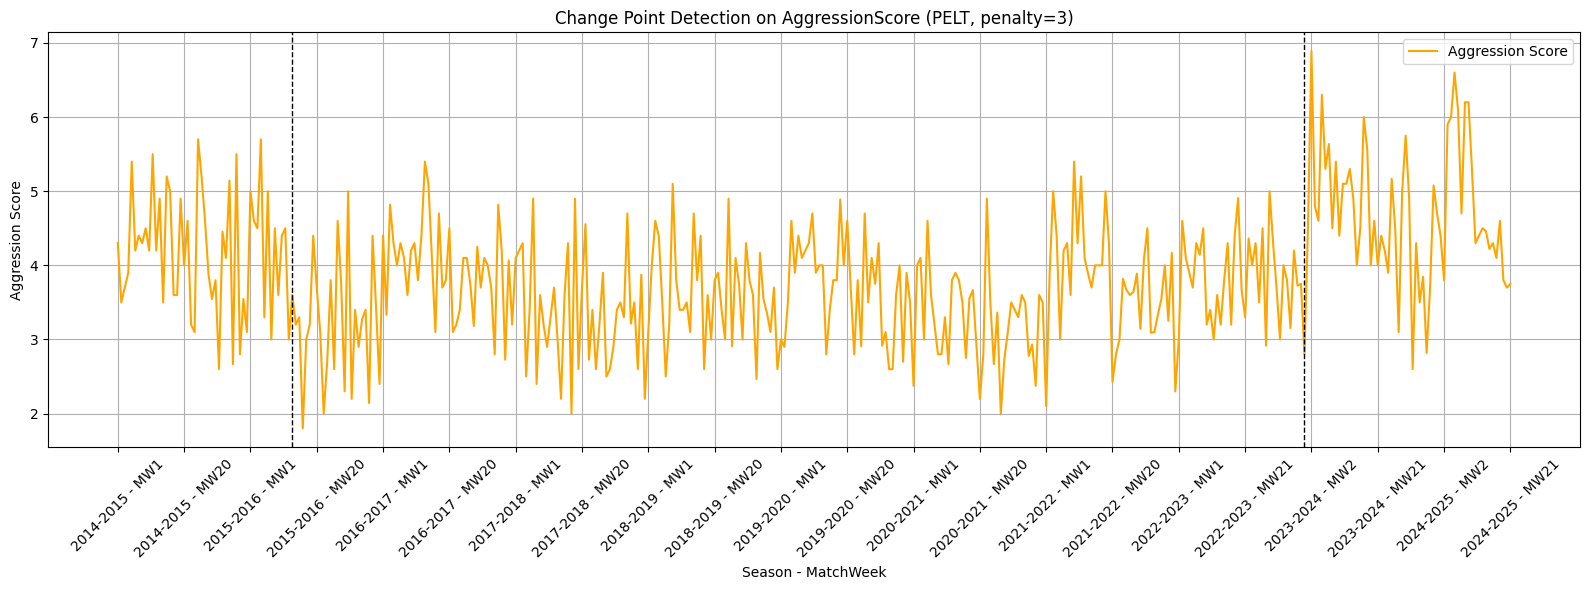

In [ ]:
plt.figure(figsize=(16, 6))
plt.plot(df_agg['ID'], signal, label="Aggression Score", color='orange')

for cp in result[:-1]:
    plt.axvline(x=cp, color='black', linestyle='--', linewidth=1)

xticks_idx = range(0, len(df_agg), 19)
plt.xticks(ticks=xticks_idx, labels=df_agg['ID'].iloc[xticks_idx], rotation=45)

plt.title(f"Change Point Detection on AggressionScore (PELT, penalty={penalty_value})")
plt.xlabel("Season - MatchWeek")
plt.ylabel("Aggression Score")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

Shewhart Control Chart

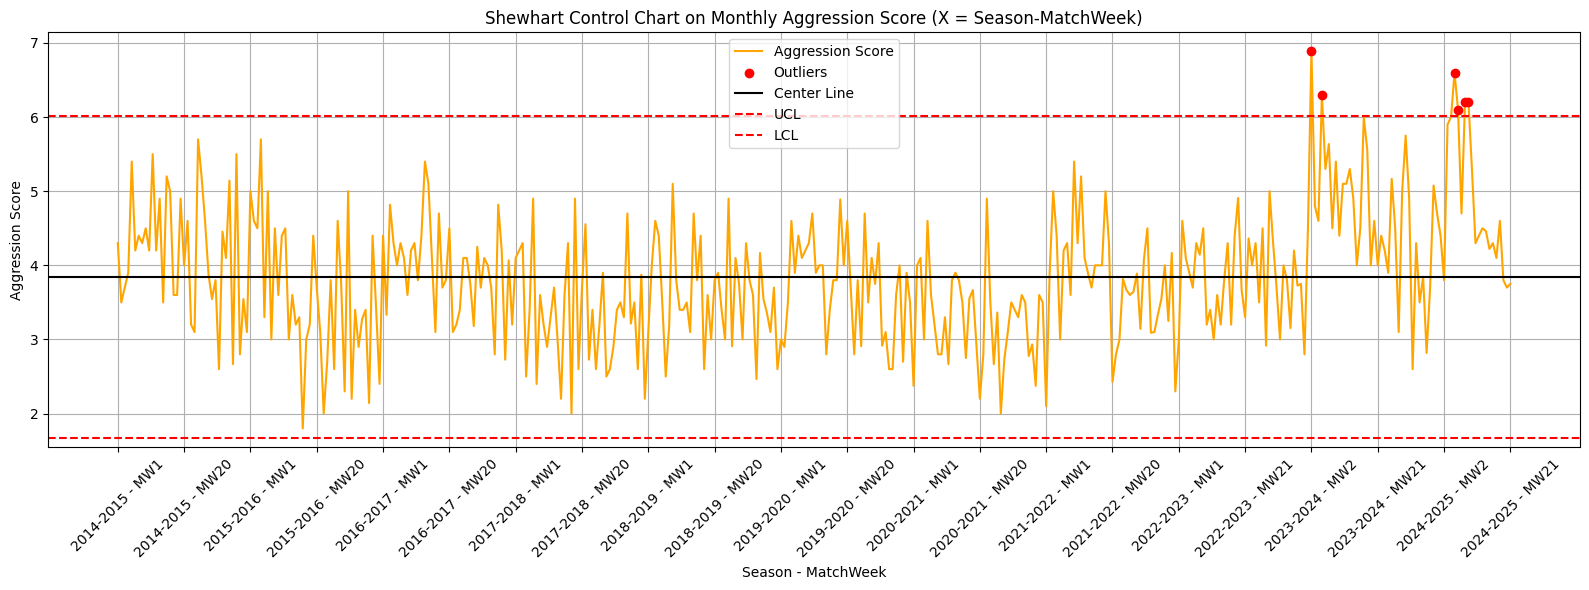

In [ ]:
# Shewhart constant
d2 = 1.128  

center_line = df_agg['AggressionScore'].mean()
moving_ranges = df_agg['AggressionScore'].diff().abs()
MR_bar = moving_ranges.mean()

UCL = center_line + 3 * MR_bar / d2
LCL = center_line - 3 * MR_bar / d2

outliers = (df_agg['AggressionScore'] > UCL) | (df_agg['AggressionScore'] < LCL)


plt.figure(figsize=(16, 6))
plt.plot(df_agg['ID'], df_agg['AggressionScore'], label='Aggression Score', color='orange')
plt.scatter(
    df_agg['ID'][outliers],
    df_agg['AggressionScore'][outliers],
    color='red',
    zorder=5,
    label='Outliers'
)
plt.axhline(center_line, color='black', linestyle='-', label='Center Line')
plt.axhline(UCL, color='red', linestyle='--', label='UCL')
plt.axhline(LCL, color='red', linestyle='--', label='LCL')

plt.xticks(ticks=np.arange(0, len(df_agg), 19), labels=df_agg['ID'].iloc[::19], rotation=45)
plt.title('Shewhart Control Chart on Monthly Aggression Score (X = Season-MatchWeek)')
plt.xlabel('Season - MatchWeek')
plt.ylabel('Aggression Score')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()